# Model 1

XGB Boost Model

In [65]:
! pip install -r requirements.txt

In [66]:
#
# basics
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_palette('magma')
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error


# warnings
import warnings
warnings.filterwarnings('ignore')

RSEED = 42

# EDA

In [67]:
# load training data
df = pd.read_csv('data/Train.csv')

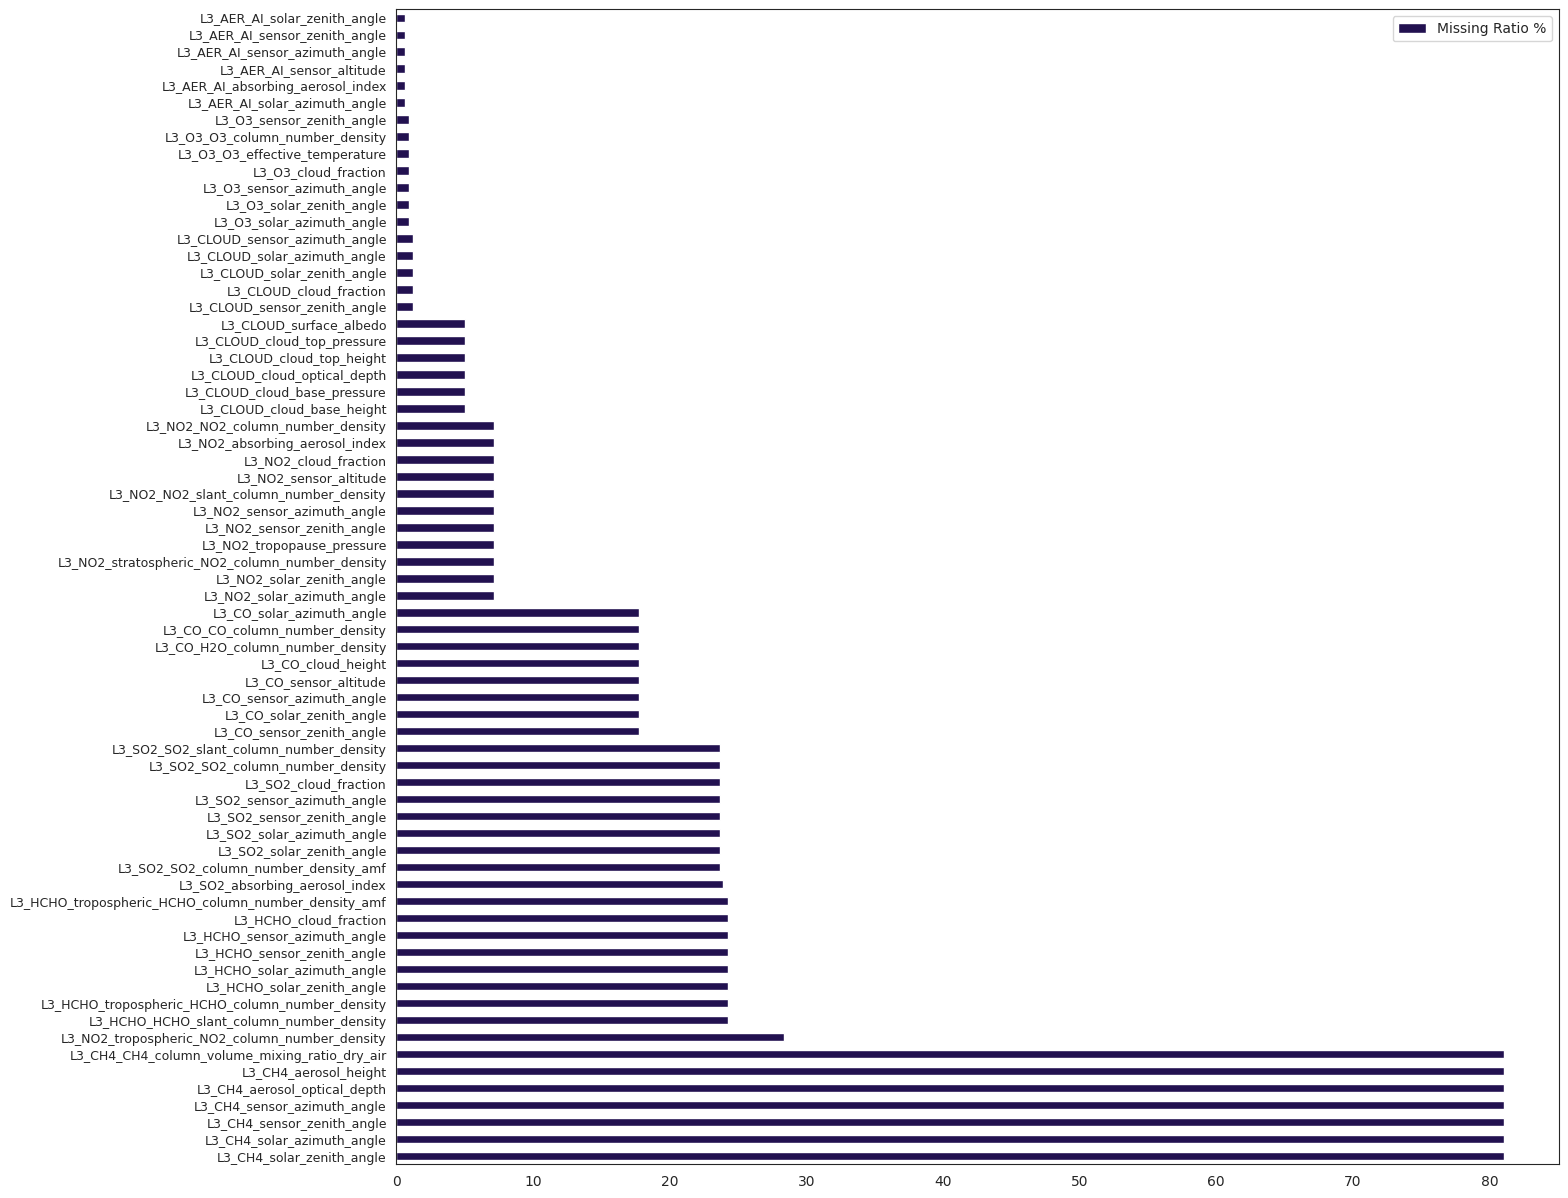

In [68]:
import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)
plot_width, plot_height = (15,15)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.rcParams['ytick.labelsize'] = 9

In [69]:
# drop columns with more than 50% missing values
check_ch4 = [col for col in df.columns if 'CH4' in col]
df.drop(columns=check_ch4, axis=1, inplace=True)

# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create integer column for weekends
df["IsWeek"] = (df["Date"].dt.weekday < 5).astype(int)

df.drop(columns=['Date', 'Place_ID', 'Place_ID X Date', 'target_min', 'target_max', 'target_variance', 'target_count'], axis=1, inplace=True)

df.head(5)

,target,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,...,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,IsWeek
0,38.0,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,...,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1
1,39.0,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,...,0.000150,0.433957,0.000050,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1
2,24.0,16.400000,33.400002,0.00750,27.031030,5.065727,3.500559,0.000067,0.000170,-1.001242,...,0.000150,0.356925,0.000053,-1.572950,0.082063,-105.201338,49.839714,-78.342701,34.296977,0
3,49.0,6.911948,21.300001,0.00391,23.971857,3.004001,1.099468,0.000083,0.000175,-0.777019,...,0.000227,0.584522,0.000110,-1.239317,0.121261,-104.334066,29.181258,-73.896588,30.545446,0
4,21.0,13.900001,44.700001,0.00535,16.816309,2.621787,2.670559,0.000070,0.000142,0.366323,...,0.000390,0.408047,0.000159,0.202489,0.037919,58.850179,0.797294,-68.612480,26.899694,1


<Axes: >

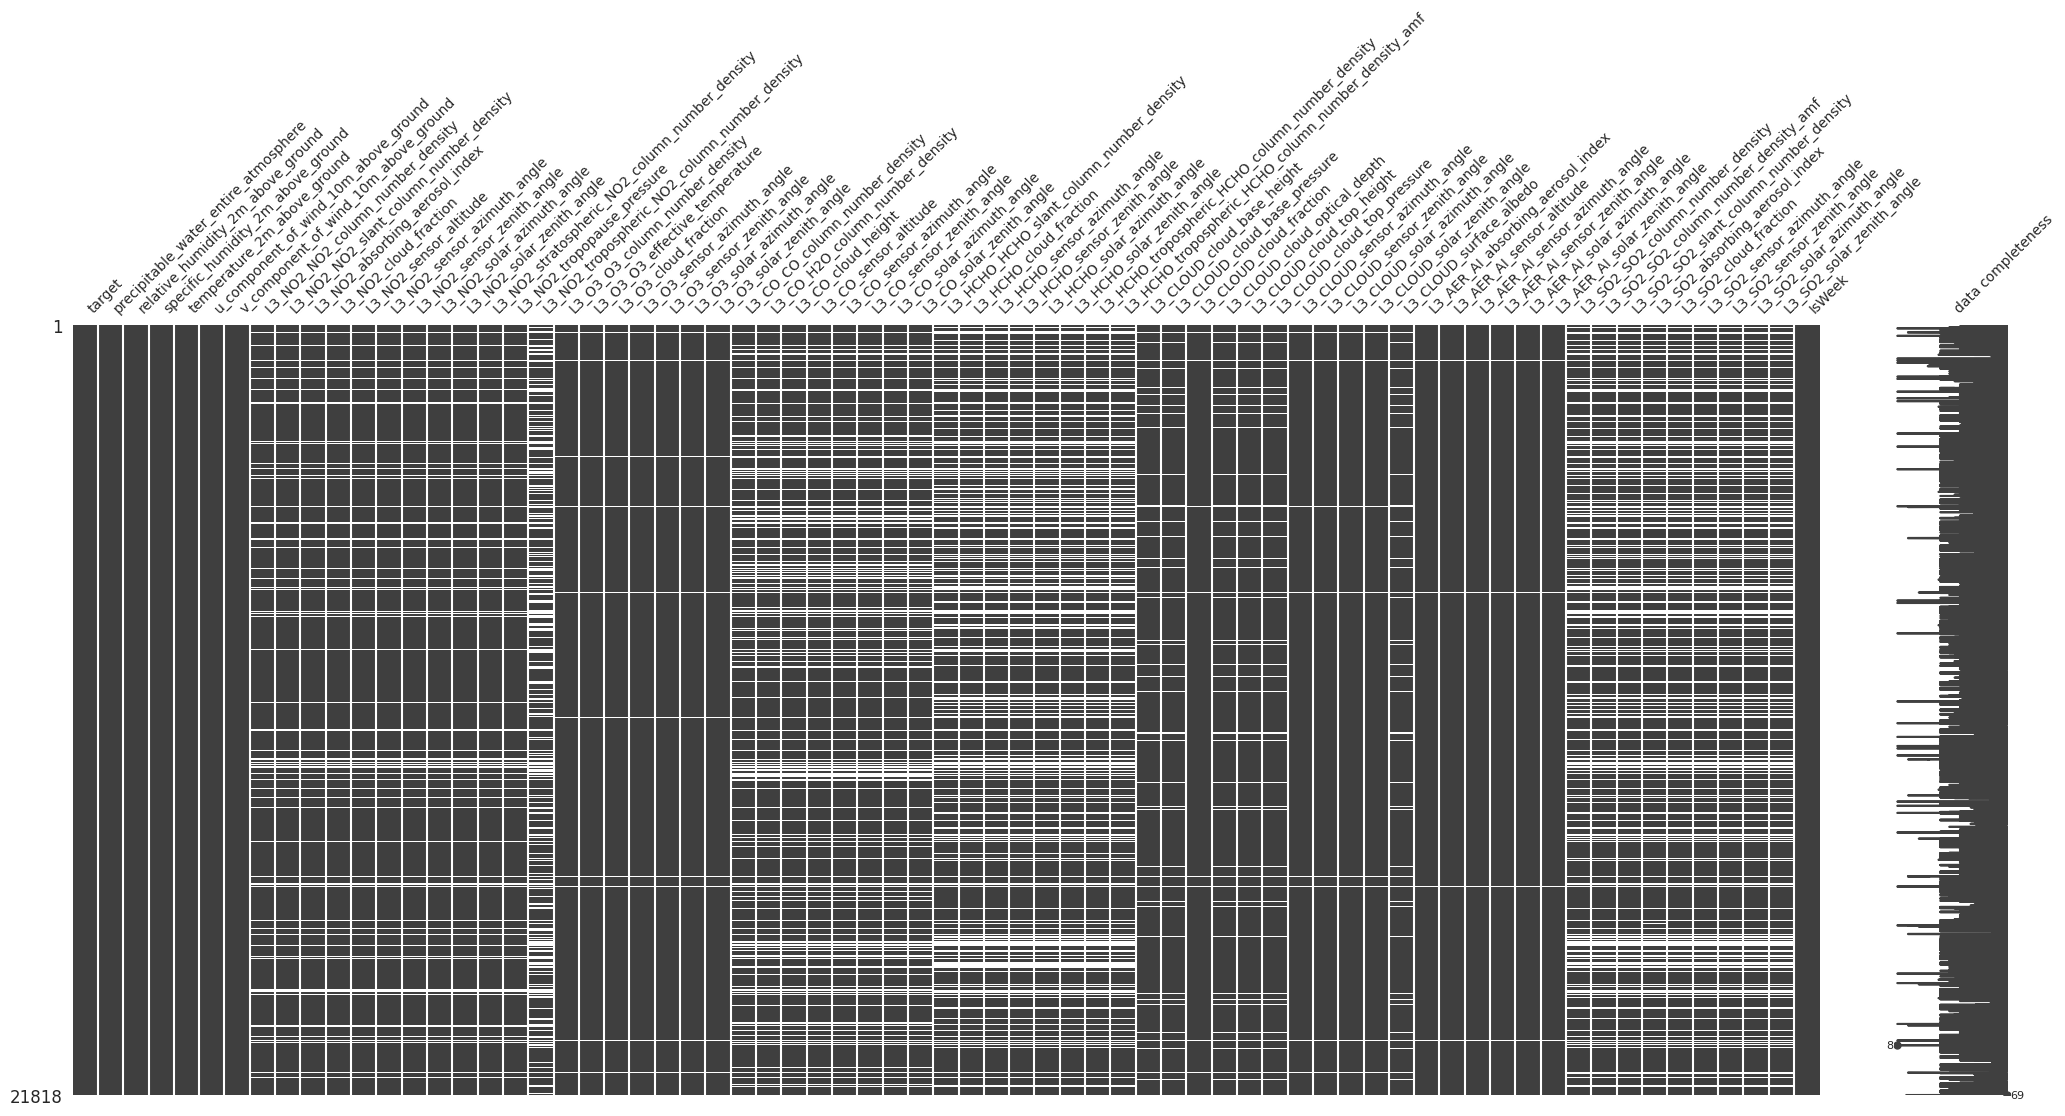

In [70]:
msno.matrix(df.query('IsWeek == 1'), fontsize=10,labels=True)

<Axes: >

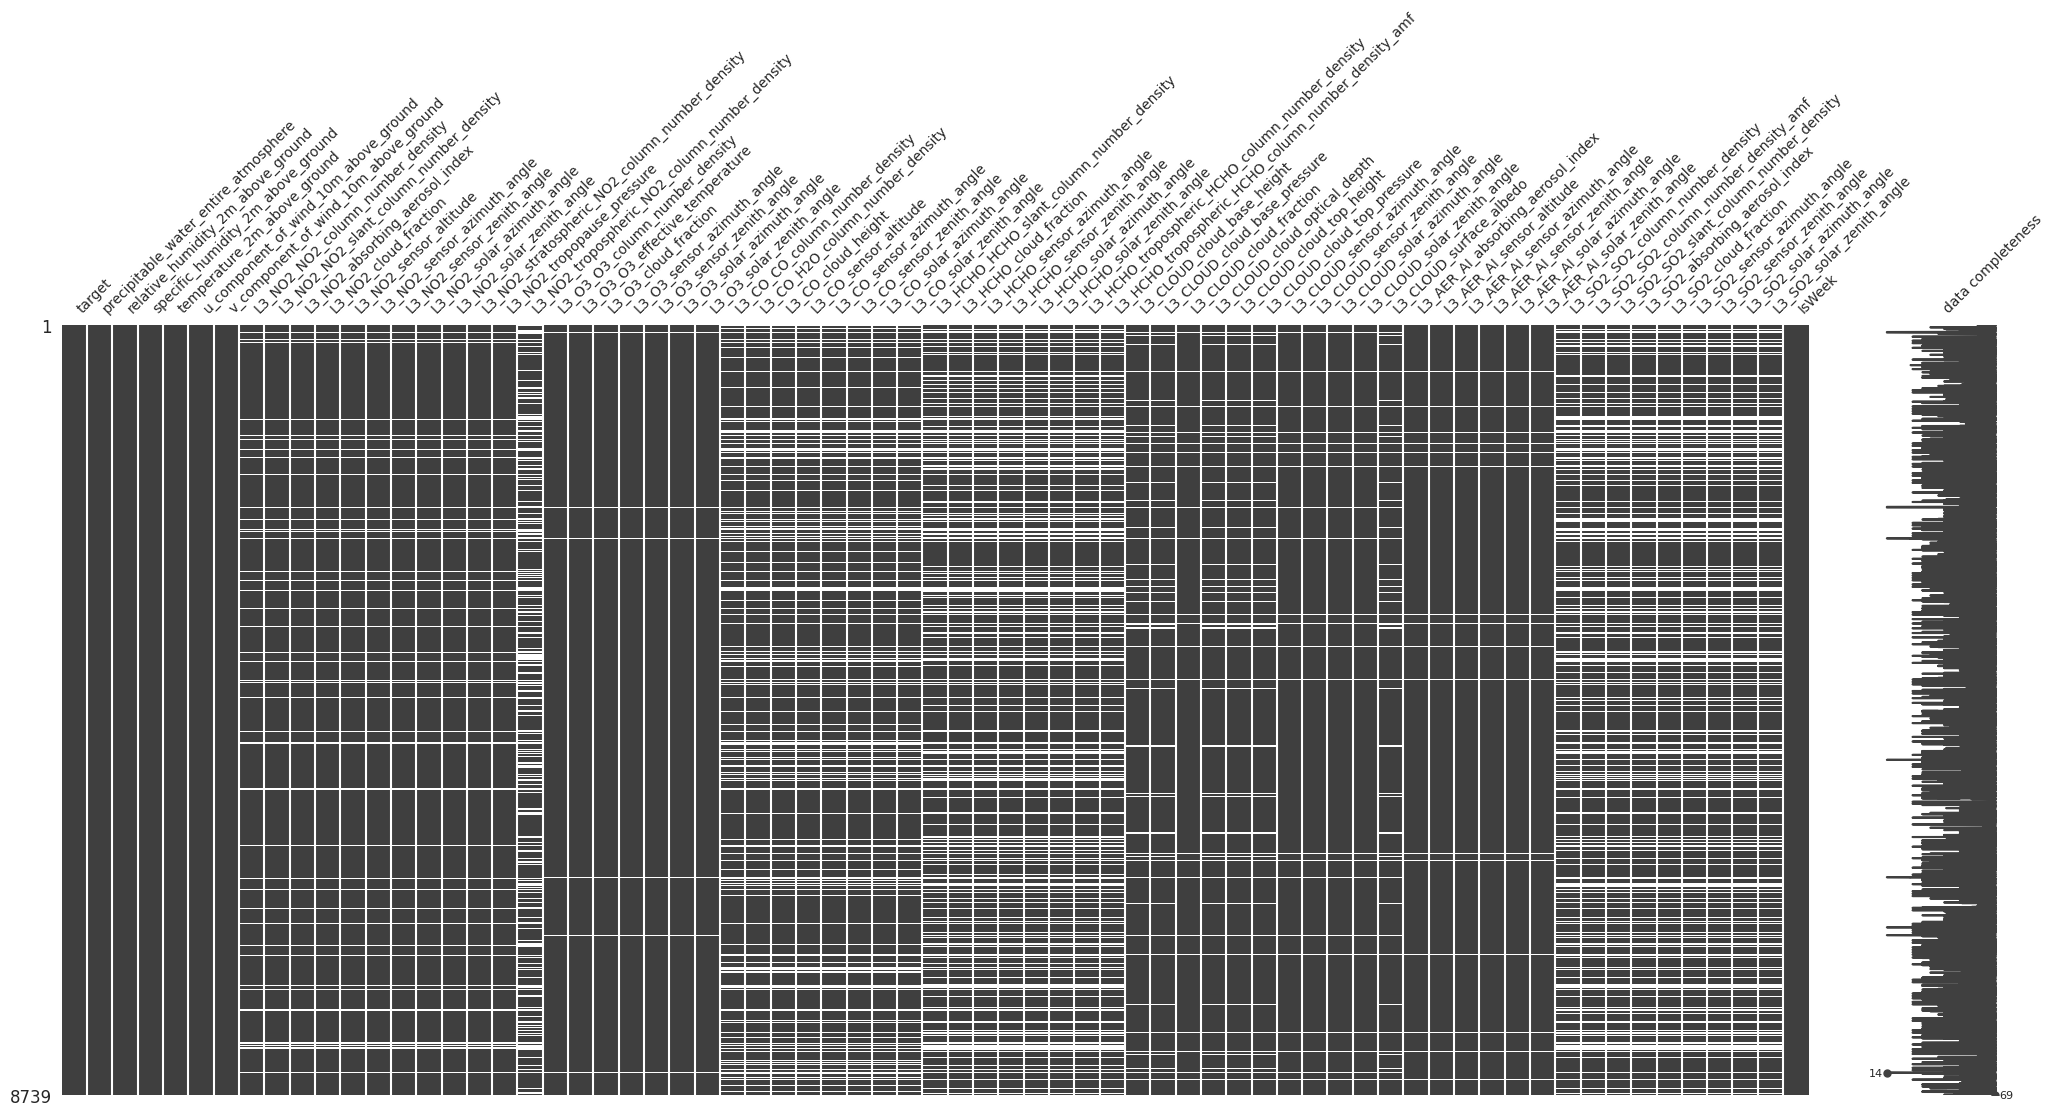

In [71]:
msno.matrix(df.query('IsWeek == 0'), fontsize=10,labels=True)

In [72]:
#removes 0 as outliers
variables_list_0_as_outlier = [
    "L3_NO2_NO2_column_number_density",
    "L3_NO2_NO2_slant_column_number_density",
    "L3_NO2_sensor_altitude",
    "L3_NO2_tropopause_pressure",
    "L3_NO2_solar_zenith_angle",
    "L3_SO2_SO2_column_number_density",
    "L3_SO2_SO2_column_number_density_amf",
    "L3_SO2_SO2_slant_column_number_density",
    "L3_SO2_solar_zenith_angle",
    "L3_O3_O3_column_number_density",
    "L3_O3_O3_effective_temperature",
    "L3_O3_solar_zenith_angle",
    "L3_CO_CO_column_number_density",
    "L3_CO_sensor_altitude",
    "L3_CO_solar_zenith_angle",
    "L3_HCHO_solar_zenith_angle",
    "L3_HCHO_tropospheric_HCHO_column_number_density_amf"
]

df[variables_list_0_as_outlier].replace(0, np.nan, inplace=True)

<Axes: >

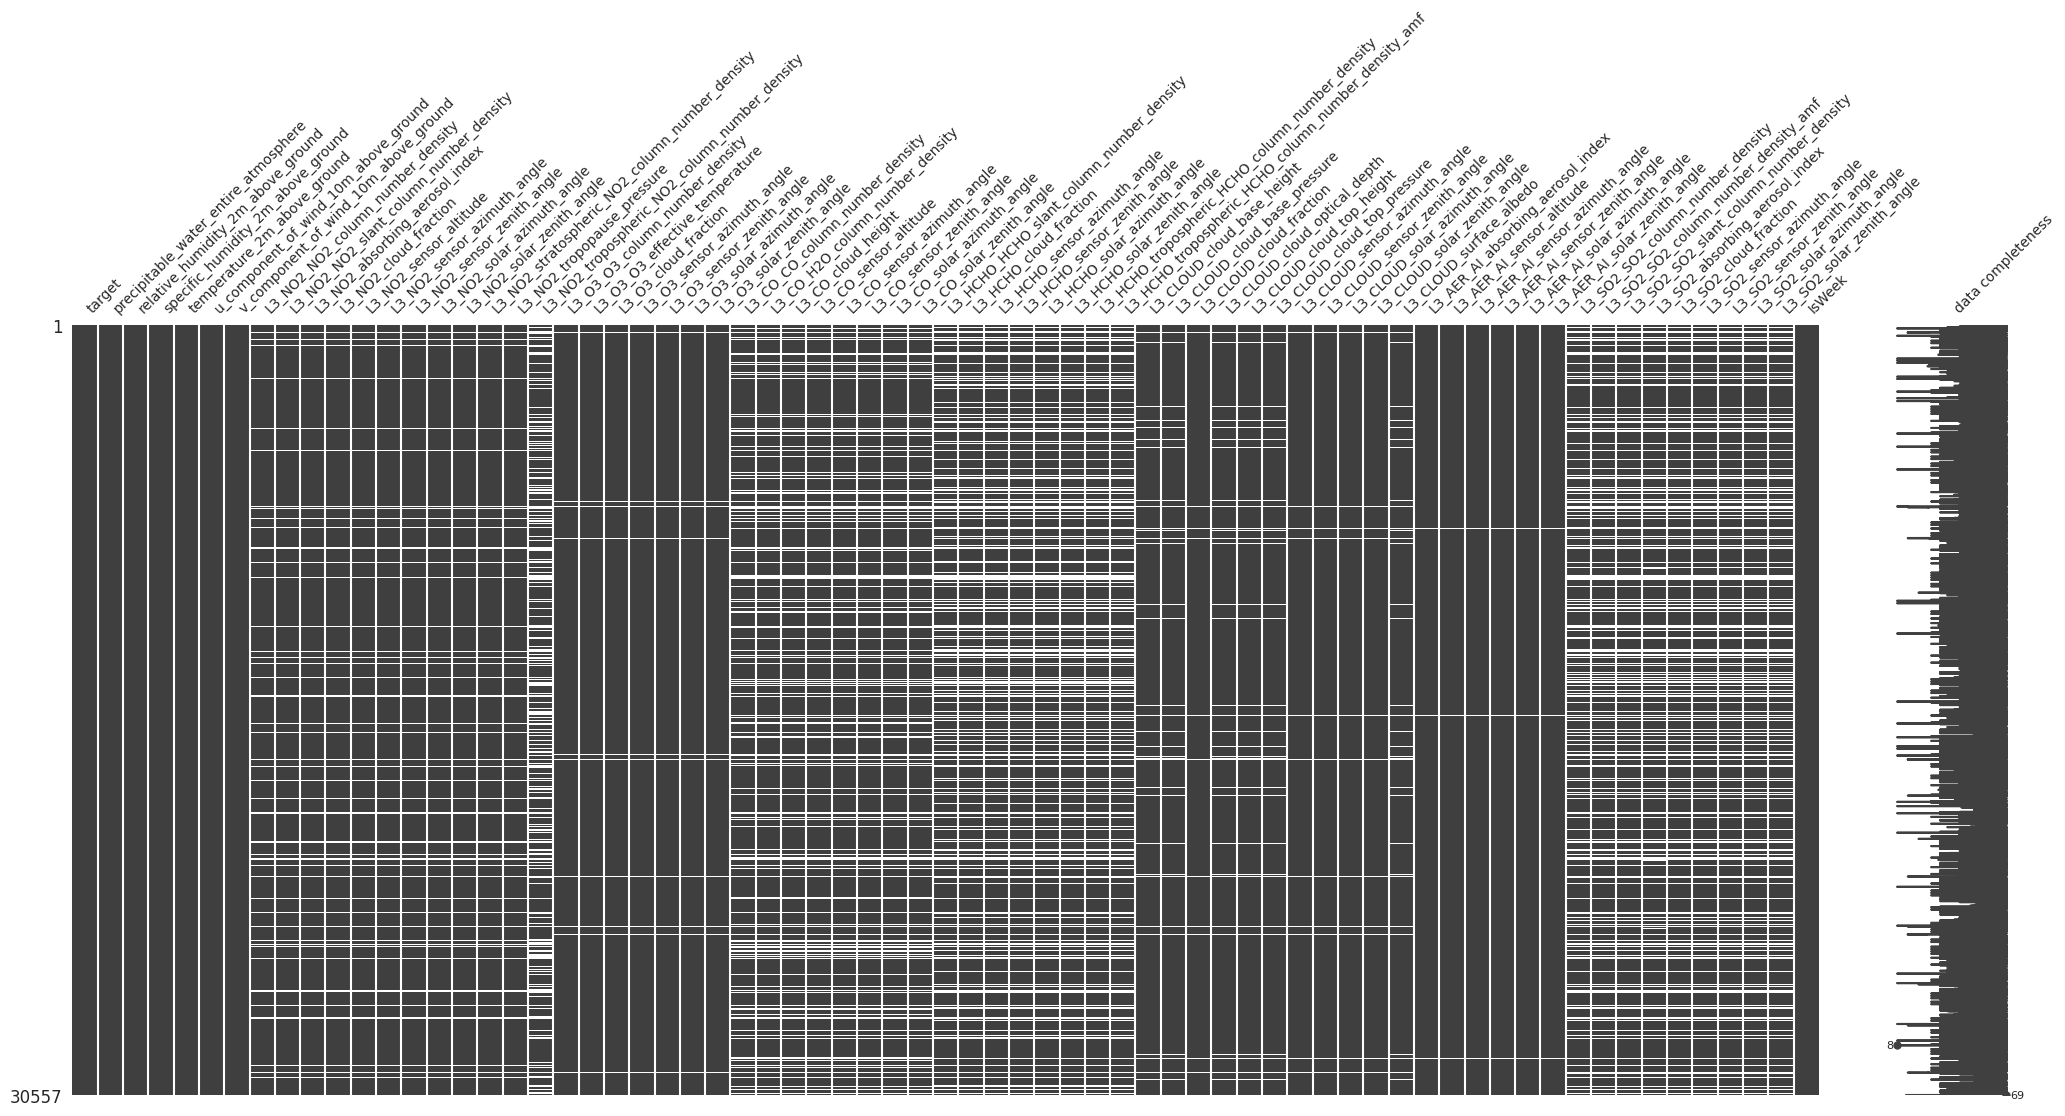

In [73]:
msno.matrix(df, fontsize=10,labels=True)

In [74]:
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## Pipeline

In [75]:
# Pipeline XGBoost Regression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb

features = list(X.columns)

num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, features),
])

pipe_xgbreg = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbreg', xgb.XGBRegressor(eta = 0.1, n_estimators=50,max_depth=10, colsample_bytree=0.8,gamma=5,reg_alpha=0,reg_lambda=10 )) 
])

pipe_xgbreg

  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['precipitable_water_entire_atmosphere',
                                                   'relative_humidity_2m_above_ground',
                                                   'specific_humidity_2m_above_ground',
                                                   'temperature_2m_above_ground',
                                                   'u_component_of_wind_10m_above_ground'...
                              eval_metric=None, feature_types=None, gamma=5,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=50,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, ...))])

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


pipe_xgbreg.fit(X_train, y_train)

y_pred_test = pipe_xgbreg.predict(X_test)
y_pred_train = pipe_xgbreg.predict(X_train)

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

mse = mean_squared_error(y_train, y_pred_train)
rmse = mse ** 0.5
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
              
            
print(f"TEST: RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}, R²: {r2_test:.3f}")
print(f"train: RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

TEST: RMSE: 29.85, MAE: 19.80, R²: 0.595
train: RMSE: 20.07, MAE: 13.07, R²: 0.816


## RandomSearch

In [77]:
# param_xgbreg = {
#               'xgbreg__n_estimators': [30],
#               'xgbreg__learning_rate': [0.08, 0.1, 0.14], 
#               'xgbreg__max_depth': [ 7, 8,],
#               'xgbreg__colsample_bytree': [0.7, 0.8, 1],
#               'xgbreg__gamma': [0.2, 0.3, 0.5],
#               'xgbreg__reg_alpha': [0],
#               'xgbreg__reg_lambda': [5, 10]
#             }

# random_search_xbreg = RandomizedSearchCV(pipe_xgbreg, param_distributions=param_xgbreg, cv=5, scoring='neg_mean_absolute_error', 
#                            verbose=1, n_jobs=-1, n_iter=50)

# random_search_xbreg.fit(X_train, y_train)
# random_search_xbreg.best_params_, random_search_xbreg.best_score_


In [78]:
# best_model = random_search_xbreg.best_estimator_
# y_test_predicted = best_model.predict(X_test)
# y_train_predicted = best_model.predict(X_train)

# print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted)))
# print("mean_absolute_error_train: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted)))



# GRIDSEARCH Finetuning

In [90]:
#GRIDSEARCH

param_xgbreg_grid = {
              'xgbreg__n_estimators': [50],
              'xgbreg__learning_rate': [0.1], 
              'xgbreg__max_depth': [10],
              'xgbreg__colsample_bytree': [0.8],
              'xgbreg__gamma': [5],
              'xgbreg__reg_alpha': [0],
              'xgbreg__reg_lambda': [10]
            }

grid_search_xbreg = GridSearchCV(pipe_xgbreg, param_grid=param_xgbreg_grid, cv=5, scoring='neg_mean_absolute_error', 
                           verbose=1, n_jobs=-1)

grid_search_xbreg.fit(X_train, y_train)
grid_search_xbreg.best_params_, grid_search_xbreg.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'xgbreg__colsample_bytree': 0.8,
  'xgbreg__gamma': 5,
  'xgbreg__learning_rate': 0.1,
  'xgbreg__max_depth': 10,
  'xgbreg__n_estimators': 50,
  'xgbreg__reg_alpha': 0,
  'xgbreg__reg_lambda': 10},
 -20.04695228283282)

In [ ]:
best_model = grid_search_xbreg.best_estimator_
# y_test_predicted_grid = best_model.predict(X_test)
# y_train_predicted_grid = best_model.predict(X_train)

# print("mean_absolute_error: {:.2f}".format(mean_absolute_error(y_test, y_test_predicted_grid)))
# print("mean_absolute_error_train: {:.2f}".format(mean_absolute_error(y_train, y_train_predicted_grid)))

# Error Analyse

Text(0.5, 1.0, 'Residuals vs. Predicted')

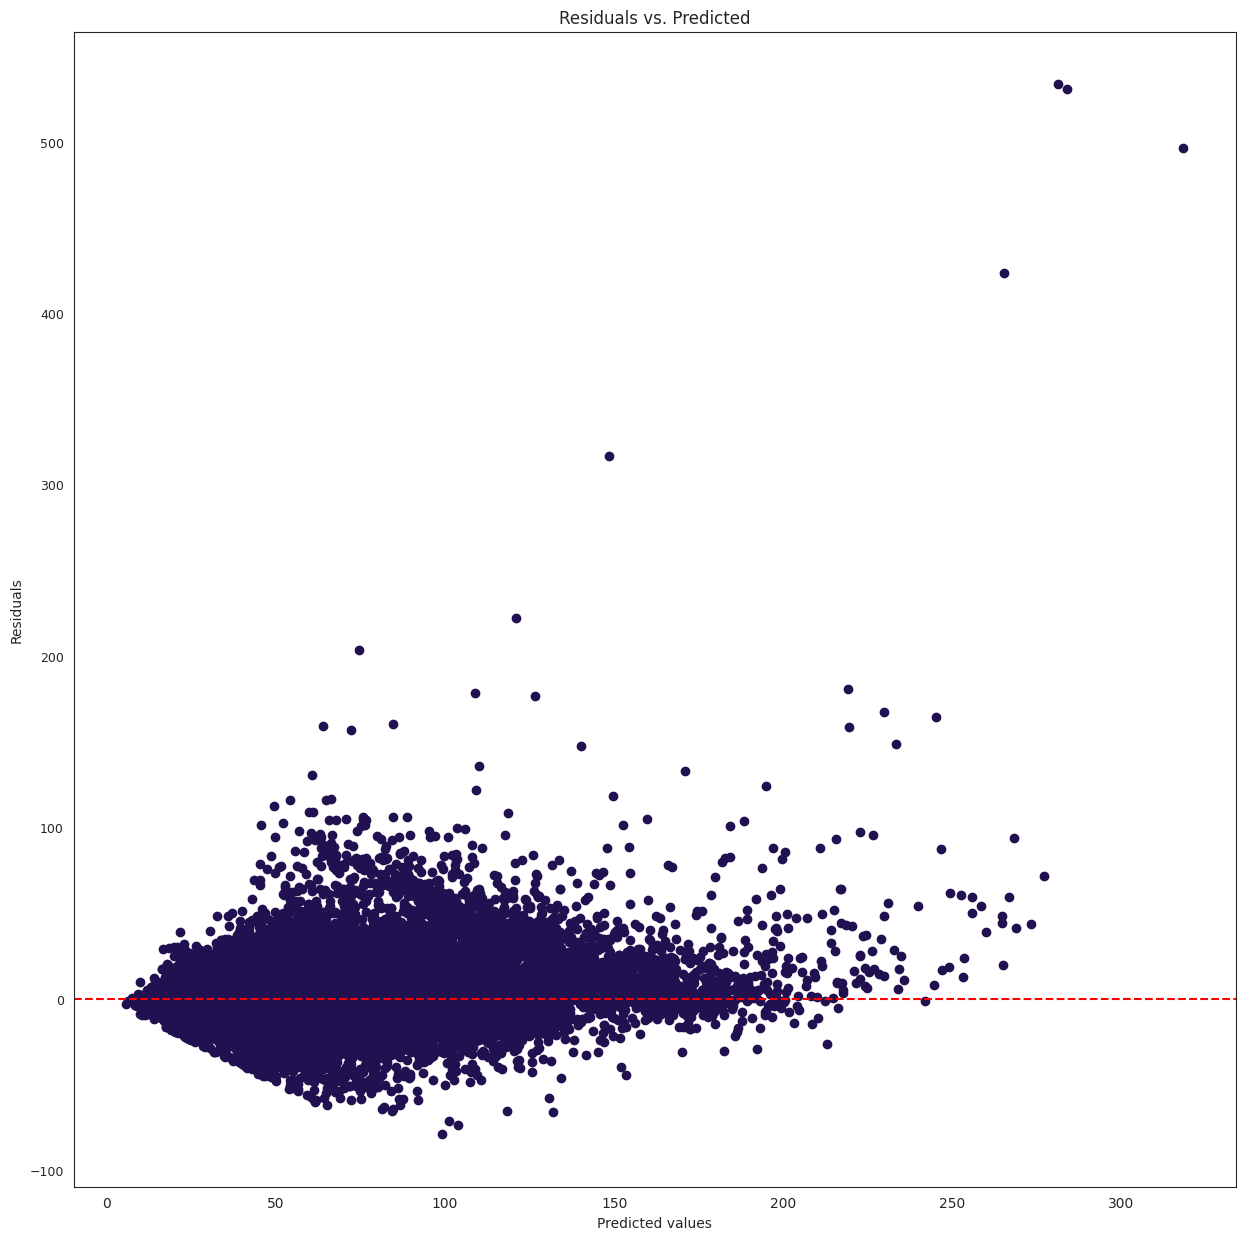

In [99]:
##

residuals = y_train-y_pred_train 

plt.scatter(x=y_pred_train,y=residuals)

plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")

Text(0.5, 1.0, 'Distribution of Residuals')

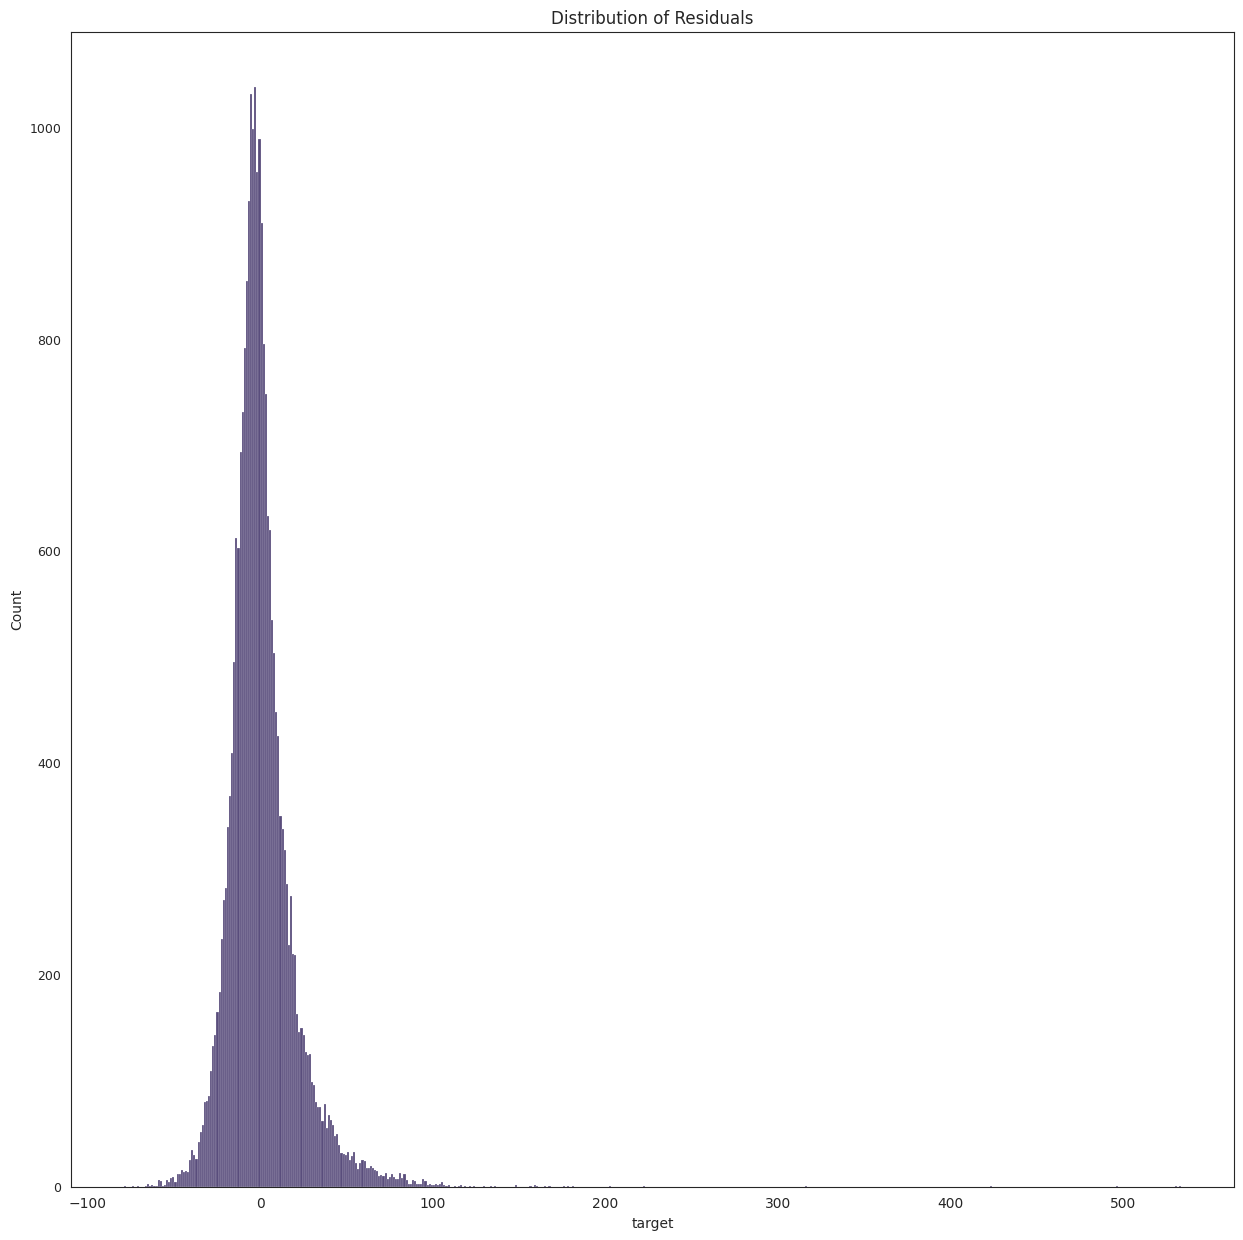

In [100]:
sns.histplot(residuals)

plt.title("Distribution of Residuals")


Text(0.5, 1.0, 'Actual vs. Predicted')

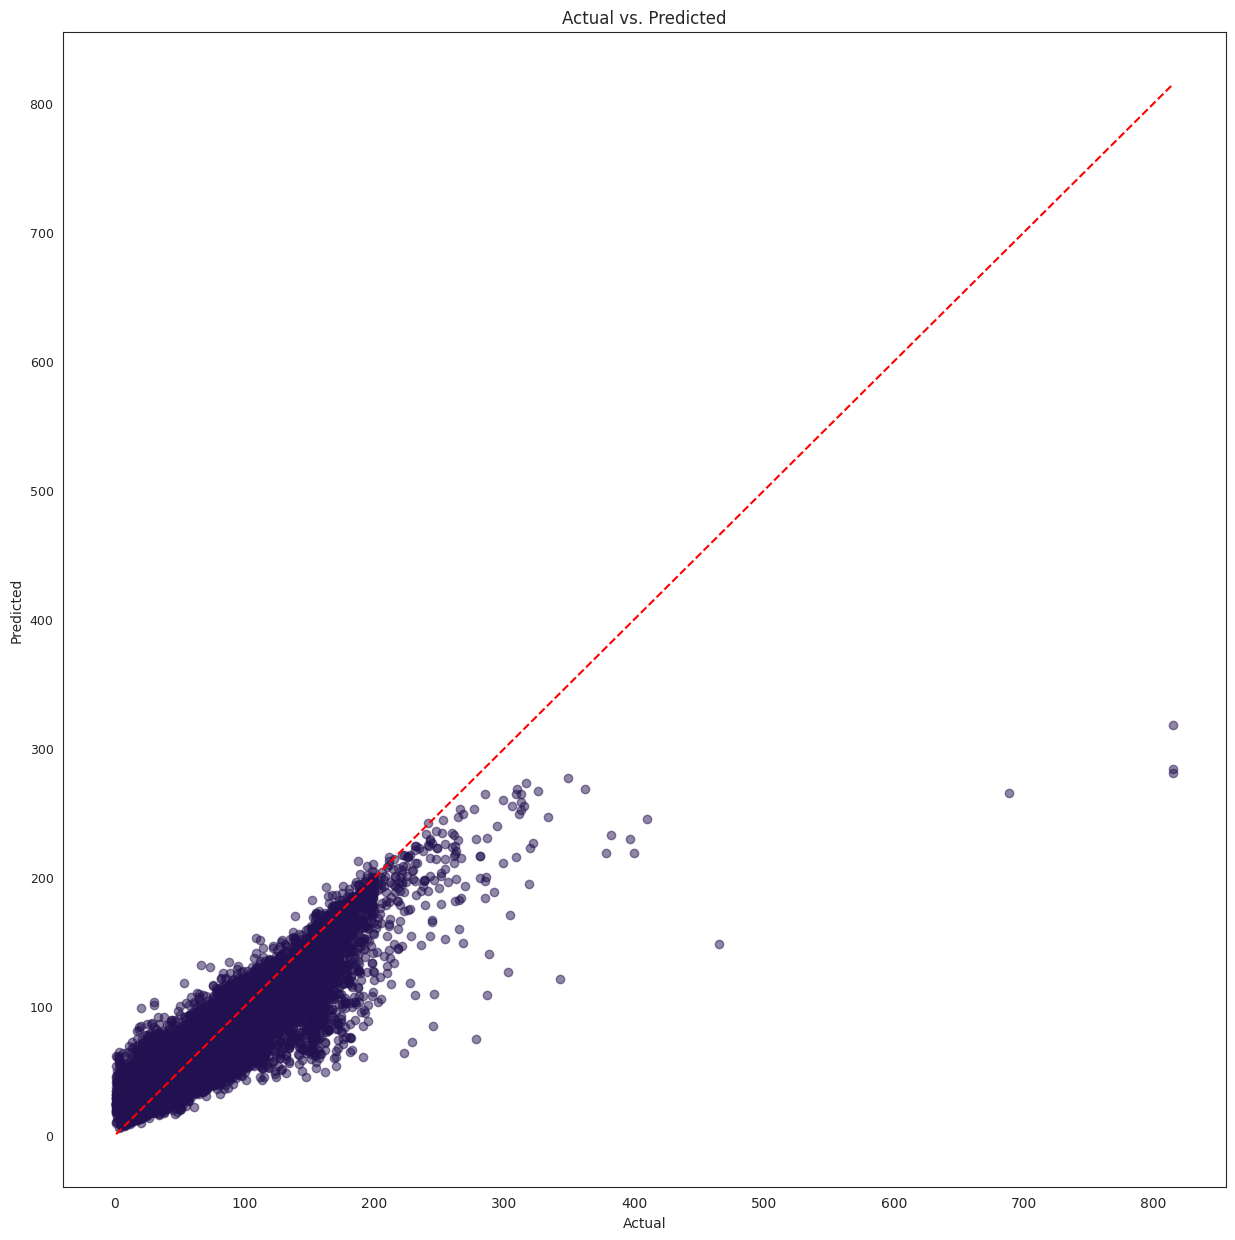

In [101]:
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")

Text(0.5, 1.0, 'Feature Importances')

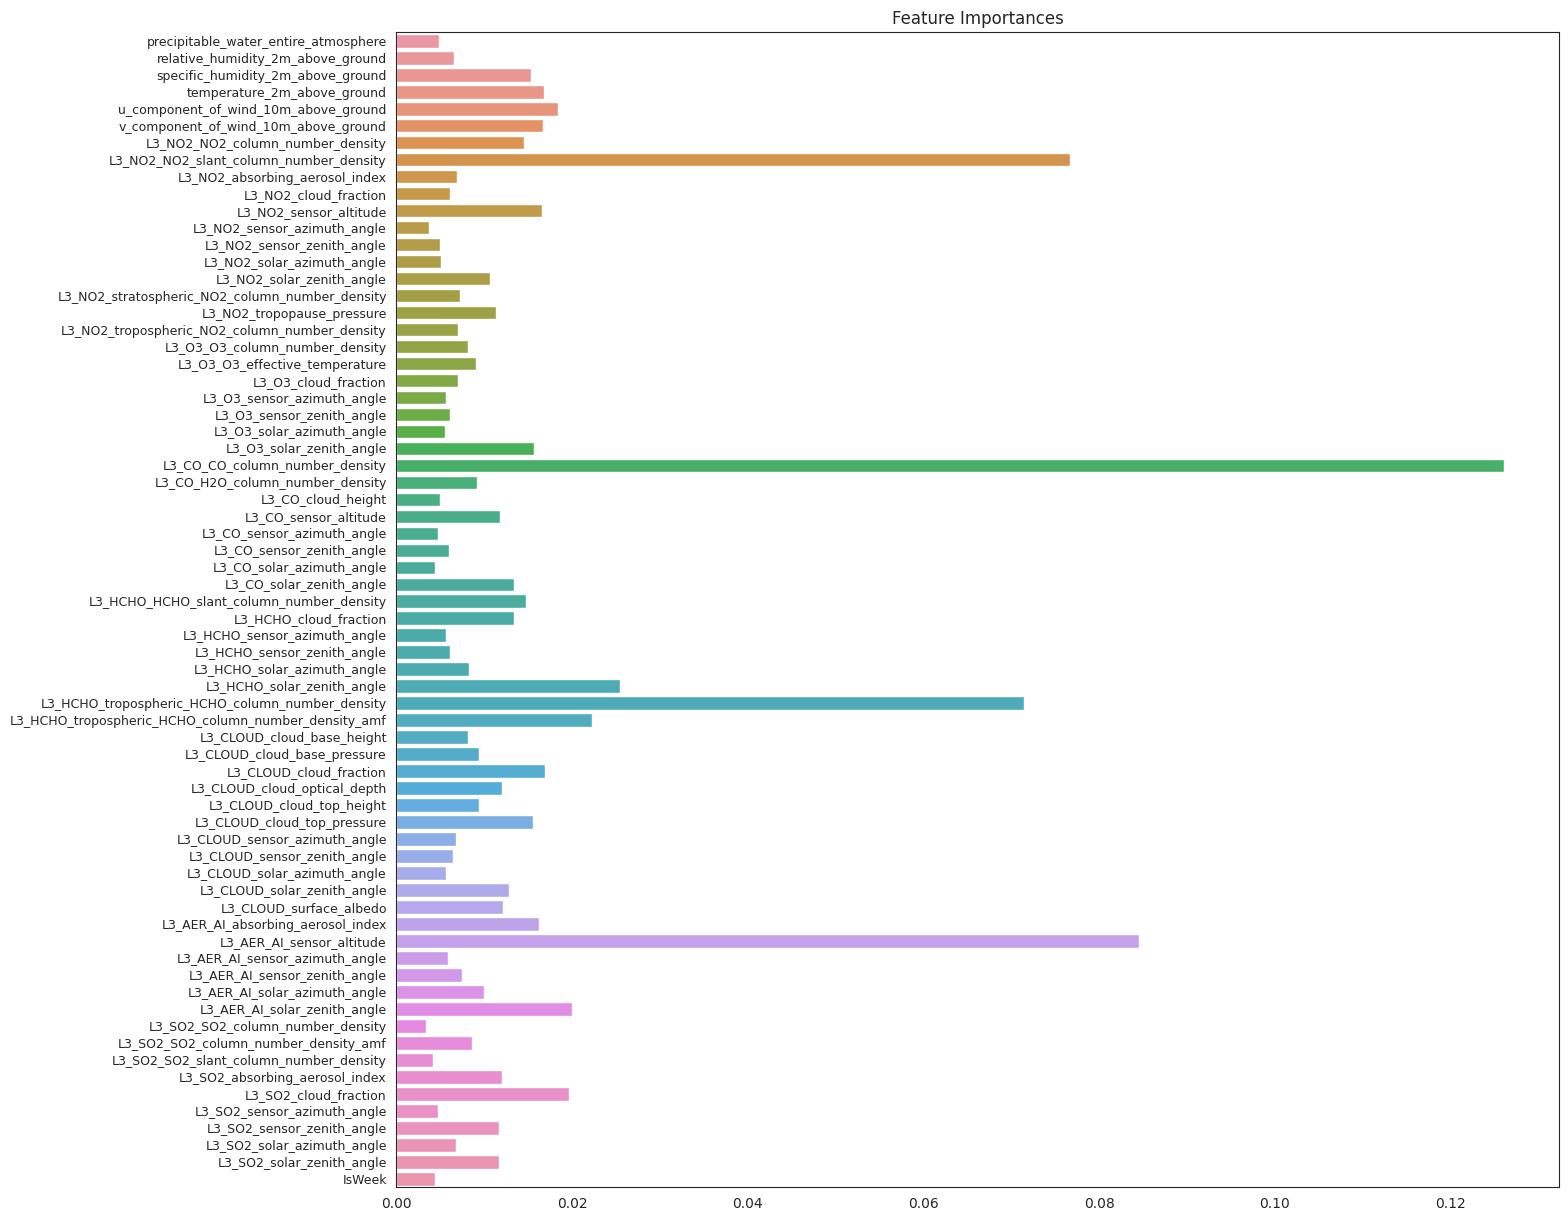

In [ ]:
reg = best_model.named_steps['xgbreg']
importances = reg.feature_importances_
feature_names = X_train.columns
# Visualize
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importances")

In [103]:
error = np.abs(y_pred_train - y_train)

In [119]:
df_erroranalyse = X_train.copy()
df_erroranalyse['y_true'] = y_train
df_erroranalyse['y_pred'] = y_pred_train
df_erroranalyse['abs_error'] = error
df_erroranalyse["rel_error"] = error/y_pred_train#df_erroranalyse["y_true"]

In [111]:
df_erroranalyse.fillna(df.median(),inplace=True)

In [118]:
top_fehler = df_erroranalyse.sort_values(by='abs_error', ascending=False).head(10)
top_fehler

,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,...,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,IsWeek,y_true,y_pred,abs_error,rel_error
4456,12.528572,29.471429,0.006174,22.243524,4.833642,3.617324,0.000046,0.000119,-0.814485,0.278440,...,0.359894,-94.545837,57.442645,-142.722236,43.375964,1,815.0,281.262665,533.737335,0.654892
4453,8.471429,23.442857,0.004474,20.786388,1.051566,2.760782,0.000059,0.000121,-0.659029,0.002930,...,0.003499,76.041288,8.056621,-157.709027,39.146939,0,815.0,283.859863,531.140137,0.651706
4465,9.671429,15.171429,0.004068,26.412230,-0.850091,-2.750546,0.000077,0.000157,-1.496870,0.050011,...,0.080639,70.281991,46.851716,-165.142246,33.428196,1,815.0,318.331940,496.668060,0.609409
8173,28.878614,41.366667,0.007327,22.028548,-3.665998,0.369468,0.000105,0.000208,3.827045,0.298012,...,0.349906,76.270666,19.202997,-66.029434,24.776411,0,689.0,265.347595,423.652405,0.614880
30300,5.216144,81.120001,0.002777,-2.808209,-0.187060,-0.479011,0.000052,0.000124,-1.289869,0.823565,...,NaN,NaN,NaN,NaN,NaN,0,465.0,148.489105,316.510895,0.680669
25822,29.200001,68.500000,0.008554,17.692560,-1.536594,-0.055513,0.000088,0.000149,0.038799,0.854838,...,NaN,NaN,NaN,NaN,NaN,1,343.0,120.999306,222.000694,0.647232
17630,14.500000,61.900002,0.005060,10.800195,-1.287849,-0.549910,0.000073,0.000149,-0.769812,0.860627,...,NaN,NaN,NaN,NaN,NaN,1,278.0,74.683998,203.316002,0.731353
17607,11.700000,56.200001,0.004330,9.991022,0.135728,0.520559,0.000144,0.000187,-1.272483,0.283986,...,0.294302,70.431013,36.955452,-168.578931,55.190426,0,400.0,219.310150,180.689850,0.451725
25234,11.800000,98.500000,0.004610,-0.017920,-0.636357,1.038752,0.000054,0.000138,-0.734078,0.974935,...,NaN,NaN,NaN,NaN,NaN,1,287.0,108.752251,178.247749,0.621072
23123,12.200000,61.000000,0.002970,3.734949,-2.441509,-3.679885,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,303.0,126.497963,176.502037,0.582515


In [107]:
top_fehler.columns

Index(['precipitable_water_entire_atmosphere',
       'relative_humidity_2m_above_ground',
       'specific_humidity_2m_above_ground', 'temperature_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'L3_NO2_NO2_column_number_density',
       'L3_NO2_NO2_slant_column_number_density',
       'L3_NO2_absorbing_aerosol_index', 'L3_NO2_cloud_fraction',
       'L3_NO2_sensor_altitude', 'L3_NO2_sensor_azimuth_angle',
       'L3_NO2_sensor_zenith_angle', 'L3_NO2_solar_azimuth_angle',
       'L3_NO2_solar_zenith_angle',
       'L3_NO2_stratospheric_NO2_column_number_density',
       'L3_NO2_tropopause_pressure',
       'L3_NO2_tropospheric_NO2_column_number_density',
       'L3_O3_O3_column_number_density', 'L3_O3_O3_effective_temperature',
       'L3_O3_cloud_fraction', 'L3_O3_sensor_azimuth_angle',
       'L3_O3_sensor_zenith_angle', 'L3_O3_solar_azimuth_angle',
       'L3_O3_solar_zenith_angle', 'L3_CO_CO_column_number_densi

In [ ]:
#top_fehler.isna().sum()
.fillna(df.median(),inplace=True)

<Axes: xlabel='y_true', ylabel='rel_error'>

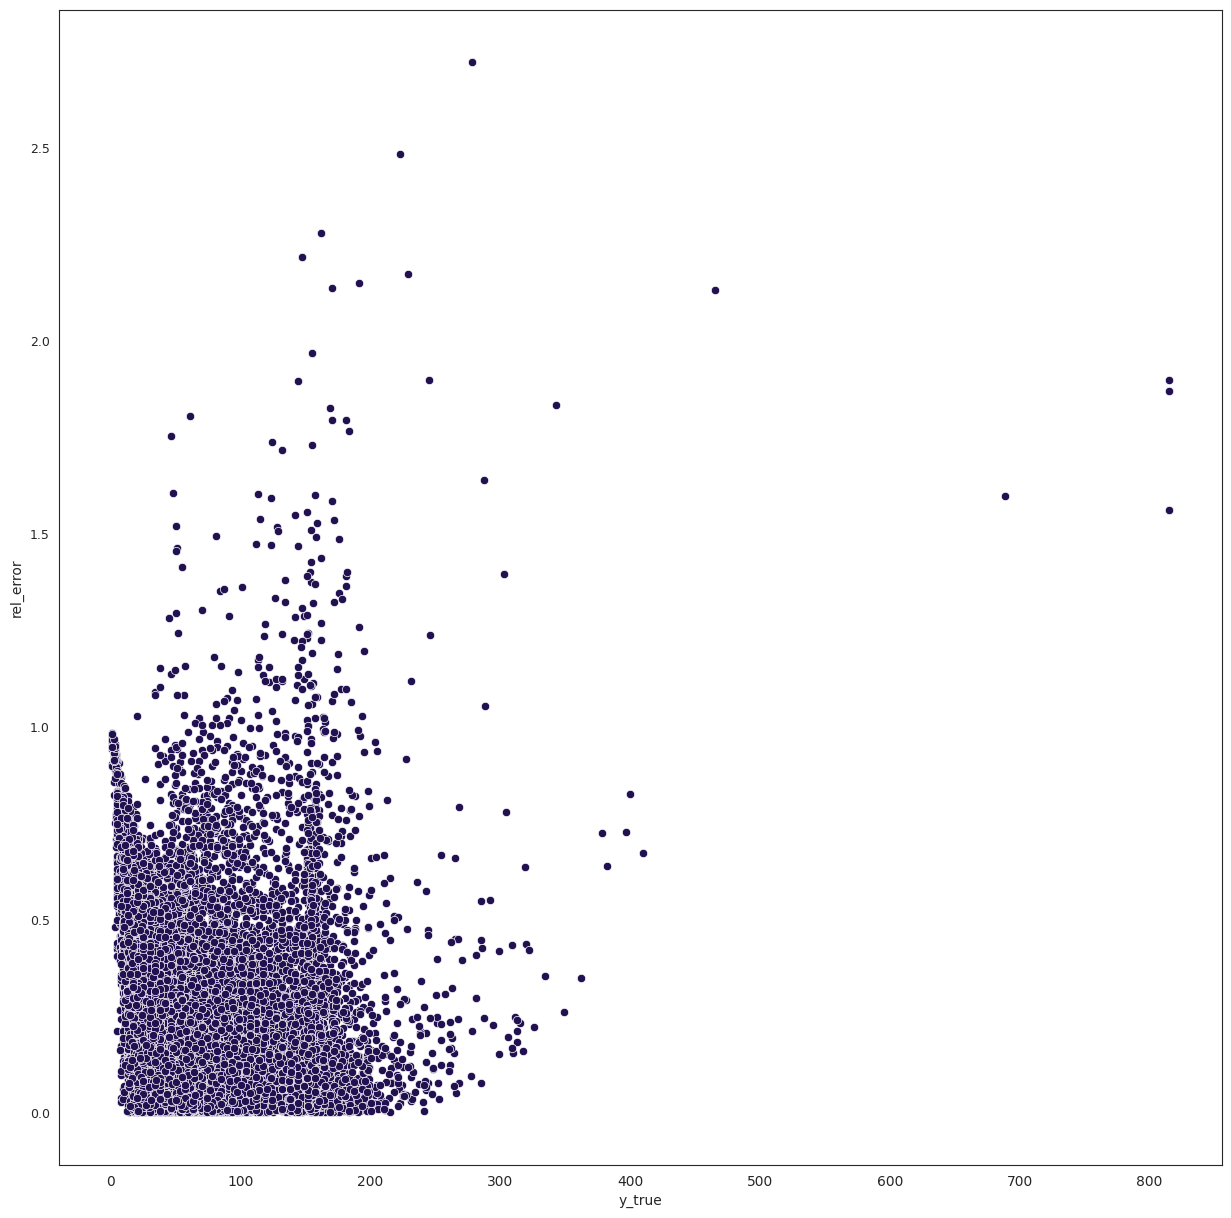

In [120]:
sns.scatterplot(data=df_erroranalyse, x="y_true", y="rel_error")


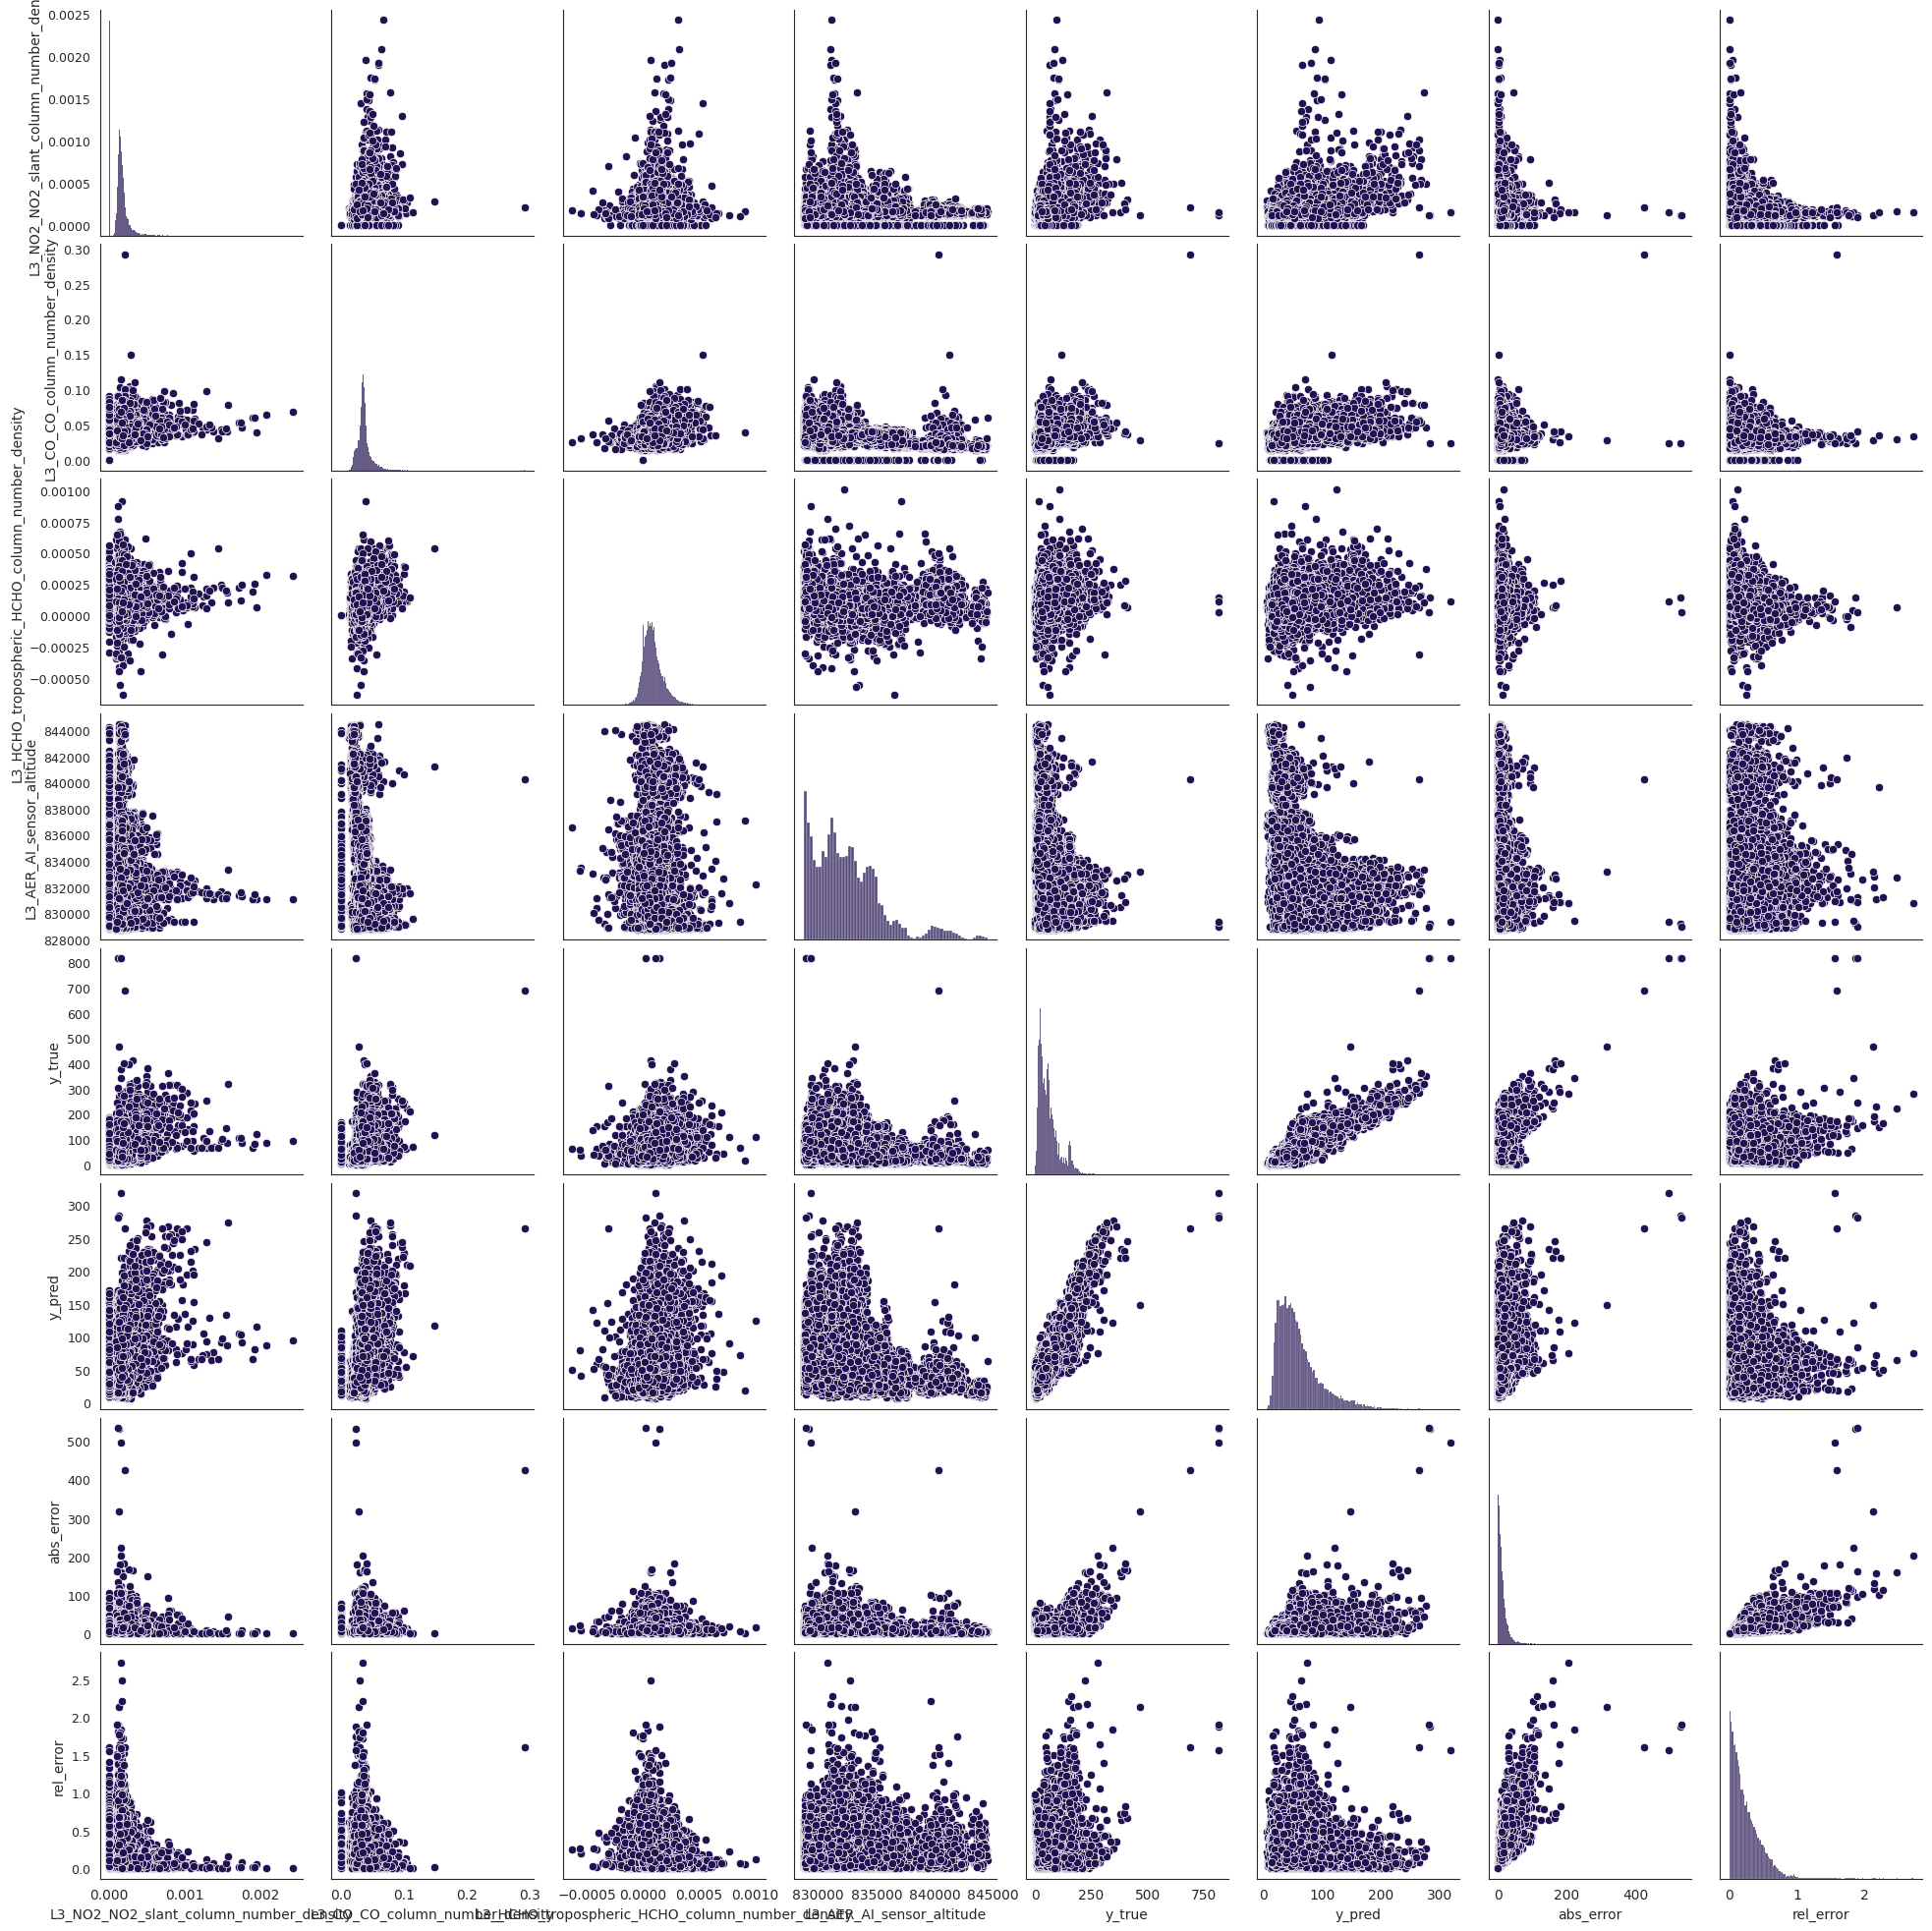

In [139]:
best_feature=list(feature_names[importances>0.04])
lst=['y_true','y_pred','abs_error','rel_error']
best_feature.extend(lst)

# best_feature

sns.pairplot(data=df_erroranalyse[best_feature])
